In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3327, done.
remote: Counting objects: 100% (3327/3327), done.
remote: Compressing objects: 100% (2750/2750), done.
remote: Total 3327 (delta 883), reused 1386 (delta 527), pack-reused 0
Receiving objects: 100% (3327/3327), 34.30 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (883/883), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1690985 sha256=d5c23e930aa5ba847b07b5cf9b12b836bca75a457d3403f3a40b697d17c3f5bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5xnuxeq/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=71e530d1eca53197be4ed3d421c7aeb7557a292855d0a6d214d6ad89e1feb9ed
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=e0f1f5316e8aa49edc73413baa261a0976800b8a330489638c92d2cf8c552b00
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=ae92e70390ba0bd061c07d5131f50a30960cf31edd116e0636

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [13]:
import matplotlib
import matplotlib.pyplot as plt


import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [33]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

In [34]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)
 
  model_dir = pathlib.Path(model_dir)/"saved_model"
 
  model = tf.saved_model.load(str(model_dir))
 
  return model
 
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
 
model_name = 'ssd_inception_v2_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
class Object_detection:
   def __init__(self,model_name,PATH_TO_LABELS):

     # Load the model

     base_url = 'http://download.tensorflow.org/models/object_detection/'
     model_file = model_name + '.tar.gz'
     model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

     model_dir = pathlib.Path(model_dir)/"saved_model"

     self.model = tf.saved_model.load(str(model_dir))
     
     self.PATH_TO_LABELS = PATH_TO_LABELS


   def load_image_into_numpy_array(self,path):
     return np.array(Image.open(path))

   def detect_object(self,image_path):
     img = self.load_image_into_numpy_array(image_path)

     input_tensor = tf.convert_to_tensor(img)
     input_tensor = input_tensor[tf.newaxis,...]

     model_fn = self.model.signatures['serving_default']
     output_dict = model_fn(input_tensor)



     num_detections = int(output_dict.pop('num_detections'))
     output_dict = {key:value[0, :num_detections].numpy() 
                      for key,value in output_dict.items()}
     output_dict['num_detections'] = num_detections

     # detection_classes should be ints.
     output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
      
    # Handle models with masks:
     if 'detection_masks' in output_dict:
       # Reframe the the bbox mask to the image size.
       detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                  img.shape[0], img.shape[1])      
       detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                          tf.uint8)
       output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

     
     category_index = label_map_util.create_category_index_from_labelmap(self.PATH_TO_LABELS, use_display_name=True)

     viz_utils.visualize_boxes_and_labels_on_image_array(
      img,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      agnostic_mode=False)
     
     return img

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


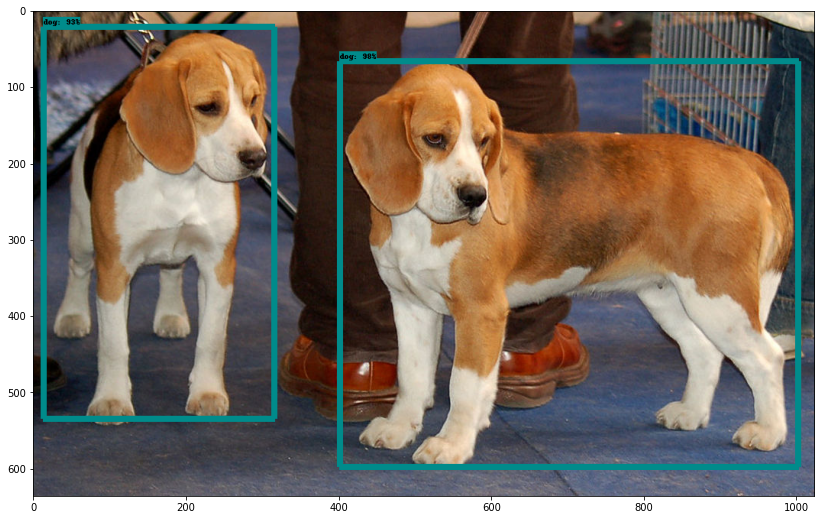

In [36]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
model_name = 'ssd_inception_v2_coco_2017_11_17'

obj_detect = Object_detection(model_name, PATH_TO_LABELS)

img  = obj_detect.detect_object(TEST_IMAGE_PATHS[0])

plt.figure(figsize=(14,10))
plt.imshow(img)
plt.show()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


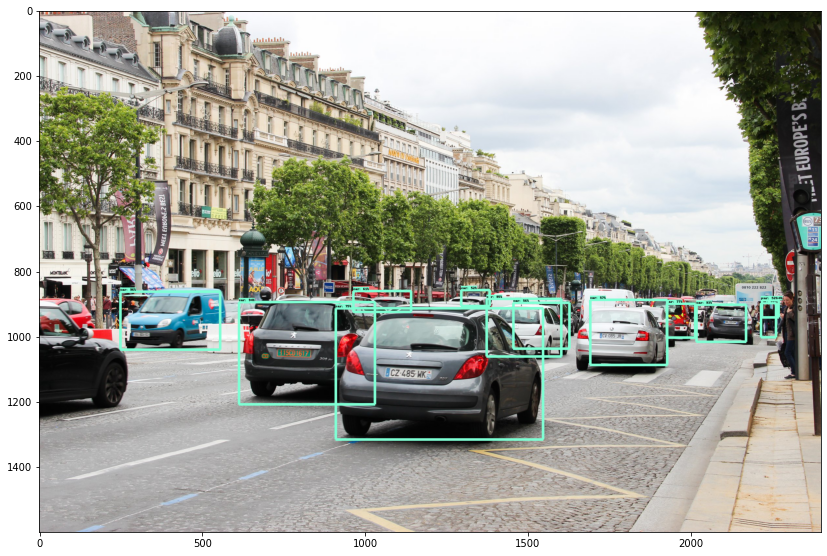

In [37]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
model_name = 'ssd_inception_v2_coco_2017_11_17'

obj_detect = Object_detection(model_name, PATH_TO_LABELS)

img  = obj_detect.detect_object('/content/Cars-on-Busy-Street.jpg')

plt.figure(figsize=(14,10))
plt.imshow(img)
plt.show()